In [1]:
from elasticsearch import Elasticsearch, RequestError, TransportError
import json
import multiprocessing
import numpy as np
import os
import pandas as pd
import time
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Set current working directory
os.chdir("../cord_19_dataset")
os.getcwd()

'/home/nrs/SideProjects/COVID19_Research_Analysis/cord_19_dataset'

**Regular-Ass Pandas Dataframes**

In [ ]:
metadata_filename = "metadata.csv"
metadata_cols = list(pd.read_csv(metadata_filename, nrows=0).columns)
metadata_cols_dtypes = {col: str for col in metadata_cols}
metadata_df = pd.read_csv(metadata_filename, dtype=metadata_cols_dtypes)

In [ ]:
metadata_df = metadata_df.dropna(subset=["title"], how="all")
metadata_df = metadata_df.fillna("")
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
doc_embeddings = tfidf_vectorizer.fit_transform(metadata_df["title"])
print(f"Embeddings type: {type(doc_embeddings)}")
print(f"pd.Series embedding shape: {doc_embeddings.shape}")

**Dask Dataframes**<br>
How to use Dask to deal with dataframes that don't fit in memory? We'll find out here.

Dask is a parallel computing library (one machine or distributed) that offers abstractions to **work with numpy and pandas datasets larger than a single machine's memory through parallel computation**. Numpy, pandas, and sklearn were not designed to scale beyond a single CPU or its machine's memory. Dask solves this problem by becoming a platform to build distributed data applications. <br>

Dask parallelizes computation via partitions. Dask dataframes are made up of many panda dataframes (i.e. partition), loaded lazily and in parallel. A single method call or computation on a Dask dataframe makes the corresponding pandas method call on each partition, all done in parallel across partitions. This also allows the programmer to interact with Dask dataframes larger than memory, **so long as each partition fits into memory**. Furthermore, Dask dataframes are *lazily loaded*, meaning that operations on a Dask dataframe builds up a task (computation) graph. Only when compute is called upon the Dask dataframe does the parallel computation execute. <br>

Thus, Dask's power comes from running intensive computations on large out-of-memory datasets in parallel with a small memory footprint.

Breaking Dask down simply, we have two components: <br>
1. **High-Level Collections:** Dask provides high-level data structures that mimic Numpy and Pandas, but can operate on datasets that don't fit into main memory in parallel. Basically, they're alternative to Numpy and Pandas for large datasets.  
2. **Low-Level Schedulers:** Dask provides dynamic task schedulers that execute task DAGs in parallel. These execution engines power computations on the above high-level collections. They allow for fast computations on out-of-memory datasets with a minimal memory footprint. Basically, they're alternatives to multiprocessing and multithreading and other task scheduling systems like Luigi.   

In [3]:
import dask.dataframe as dd
from dask.distributed import Client

num_cpu_cores = multiprocessing.cpu_count()
client = Client(n_workers=num_cpu_cores)  # Set to number of cores of machine
client.cluster

In [ ]:
from time import sleep

def inc(x):
    # sleep(1)
    return x + 1

def add(x, y):
    # sleep(1)
    return x + y

In [ ]:
%%time
from dask import delayed

# This runs immediately, all it does is build a graph
# delayed(computation_func_name)(param_0, param_1, ...) where params can also be dask.Delayed objects

x = delayed(inc)(1)  # Computation graph with one node
y = delayed(inc)(2)  # Computation graph with one node
z = delayed(add)(x, y)  # Computation graph with three nodes

In [ ]:
%%time

x.visualize()
# z = lazy dask.Delayed object (computation graph)
# z.compute() passes computation graph into an execution engine 
# (which parallelizes workload with minimal memory footprint), 
# yielding actual result of computation
z.compute() 
z.visualize()  # Visualize computation graph

**Parallelizing Computations using Dask**

In [ ]:
%%time

data = [1, 2, 3, 4, 5, 6, 7, 8]
results = []

for x in data:
    y = delayed(inc)(x)  # Reminder: doesn't actually perform computation here
    results.append(y)  # Add dask.Delayed object to list

# Params = list of dask.Delayed objects, total = dask.Delayed object (contains computation DAG)
# No actual computation performed below; just building the computation DAG!
total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed
total.visualize()

**Apply Dask to CORD19 Dataset**

In [17]:
metadata_filename = "metadata.csv"
metadata_cols = [
    "cord_uid", "title", "authors", "abstract", "publish_time", "url", "journal", "pdf_json_files",
]
metadata_cols_dtypes = {col: str for col in metadata_cols}
metadata_dd = dd.read_csv(metadata_filename, dtype=metadata_cols_dtypes, usecols=metadata_cols)
# metadata_dd.visualize()

Computations when building the elasticsearch index:<br>
File: `build_research_paper_index.py` <br>
1. `retrieve_paper_body_text` (bunch of file reads and string appending via loops)
2. `remove_papers_with_null_cols` (pandas df mutation)
3. `fill_in_missing_data` (pandas df mutation)
4. `generate_embeddings` (mathematical operations like dot products and sums) <br>
The goal is not to parallelize the computations themselves. What we want to parallelize is its operation on the out-of-memory Dask dataframe. Thus, there will be 4 separate computation graphs, each one having a computation node for each partition of the Dask dataframe. 

In [18]:
%%time

print(f"Num rows before: {metadata_dd.shape[0].compute()}")
metadata_dd = metadata_dd.dropna(subset=["title"], how="all")  # remove_papers_with_null_cols
metadata_dd = metadata_dd.dropna(subset=["abstract", "url"], how="all")  # remove_papers_with_null_cols
print(f"Num rows after: {metadata_dd.shape[0].compute()}")
print(f"Null cols before: {metadata_dd.columns[metadata_dd.isna().any().compute()].tolist()}")
metadata_dd = metadata_dd.fillna("")  # fill_in_missing_data
print(f"Null cols after: {metadata_dd.columns[metadata_dd.isna().any().compute()].tolist()}")

Num rows before: 379974
Num rows after: 328190
Null cols before: ['abstract', 'publish_time', 'authors', 'journal', 'pdf_json_files', 'url']
Null cols after: []
CPU times: user 484 ms, sys: 54 ms, total: 538 ms
Wall time: 7.41 s


In [19]:
print(f"Metadata dd shape: {metadata_dd.shape}")  # (Delayed shape, # cols)
print(f"Metadata dd types: {metadata_dd.dtypes}")
print(f"Metadata dd # partitions: {metadata_dd.npartitions}")
print(f"Metadata dd index: {metadata_dd.index}")

Metadata dd shape: (Delayed('int-5876525a-6449-4f12-944e-19475e91fd38'), 8)
Metadata dd types: cord_uid          object
title             object
abstract          object
publish_time      object
authors           object
journal           object
pdf_json_files    object
url               object
dtype: object
Metadata dd # partitions: 9
Metadata dd index: Dask Index Structure:
npartitions=9
    int64
      ...
    ...  
      ...
      ...
dtype: int64
Dask Name: fillna, 63 tasks


In [20]:
%%time

cleaned_metadata_df = metadata_dd.compute(scheduler="processes")
print(f"Metadata dd memory usage: {cleaned_metadata_df.memory_usage(deep=True).sum()}")  # 741MB
print(f"Metadata dd shape: {cleaned_metadata_df.shape}")  # (328190, 8)

Metadata dd memory usage: 741221421
Metadata dd shape: (328190, 8)
CPU times: user 7.39 s, sys: 1.88 s, total: 9.27 s
Wall time: 12.1 s


In [21]:
def retrieve_paper_body_text(pdf_json_files: str) -> str:
    if pdf_json_files and type(pdf_json_files) is str:
        for json_path in pdf_json_files.split("; "):
            paper_body_text = []

            try:
                with open(json_path) as paper_json:
                    full_text_dict = json.load(paper_json)

                    for paragraph_dict in full_text_dict["body_text"]:
                        paragraph_text = paragraph_dict["text"]
                        section_name = paragraph_dict["section"]
                        if section_name.lower() != "abstract":
                            paper_body_text.append(paragraph_text)

                if paper_body_text:  # Stop searching through pdf_json_files
                    return "\n".join(paper_body_text)
            except FileNotFoundError as e:
                print(f"Failed on {json_path} with exception: {str(e)}")

    return ""

def retrieve_paper_body_text_for_series(pdf_json_files_series: pd.Series) -> pd.Series:
    return pdf_json_files_series.apply(lambda pdf_json_files: retrieve_paper_body_text(pdf_json_files))

def generate_embeddings(embedding_type: str, docs: pd.Series) -> pd.Series:
    if embedding_type == "tfidf":
        tfidf_vectorizer = TfidfVectorizer(stop_words='english')
        doc_embeddings = tfidf_vectorizer.fit_transform(docs)
        print(f"Title embeddings shape: {doc_embeddings.toarray()}")
    else:
        try:
            # TODO: Correctly load and generate embeddings using CORD19 embeddings and HuggingFace transformers lib
            embeddings = DEEP_EMBEDDINGS_MAP[embedding_type]
        except KeyError:
            raise KeyError(
                f"Embedding type {embedding_type} nonexistent in embedding map: {DEEP_EMBEDDINGS_MAP}. Make sure the embedding type exists as a key in the embedding map."
            )

    return doc_embeddings

Failed on foo with exception: [Errno 2] No such file or directory: 'foo'
Failed on foo with exception: [Errno 2] No such file or directory: 'foo'


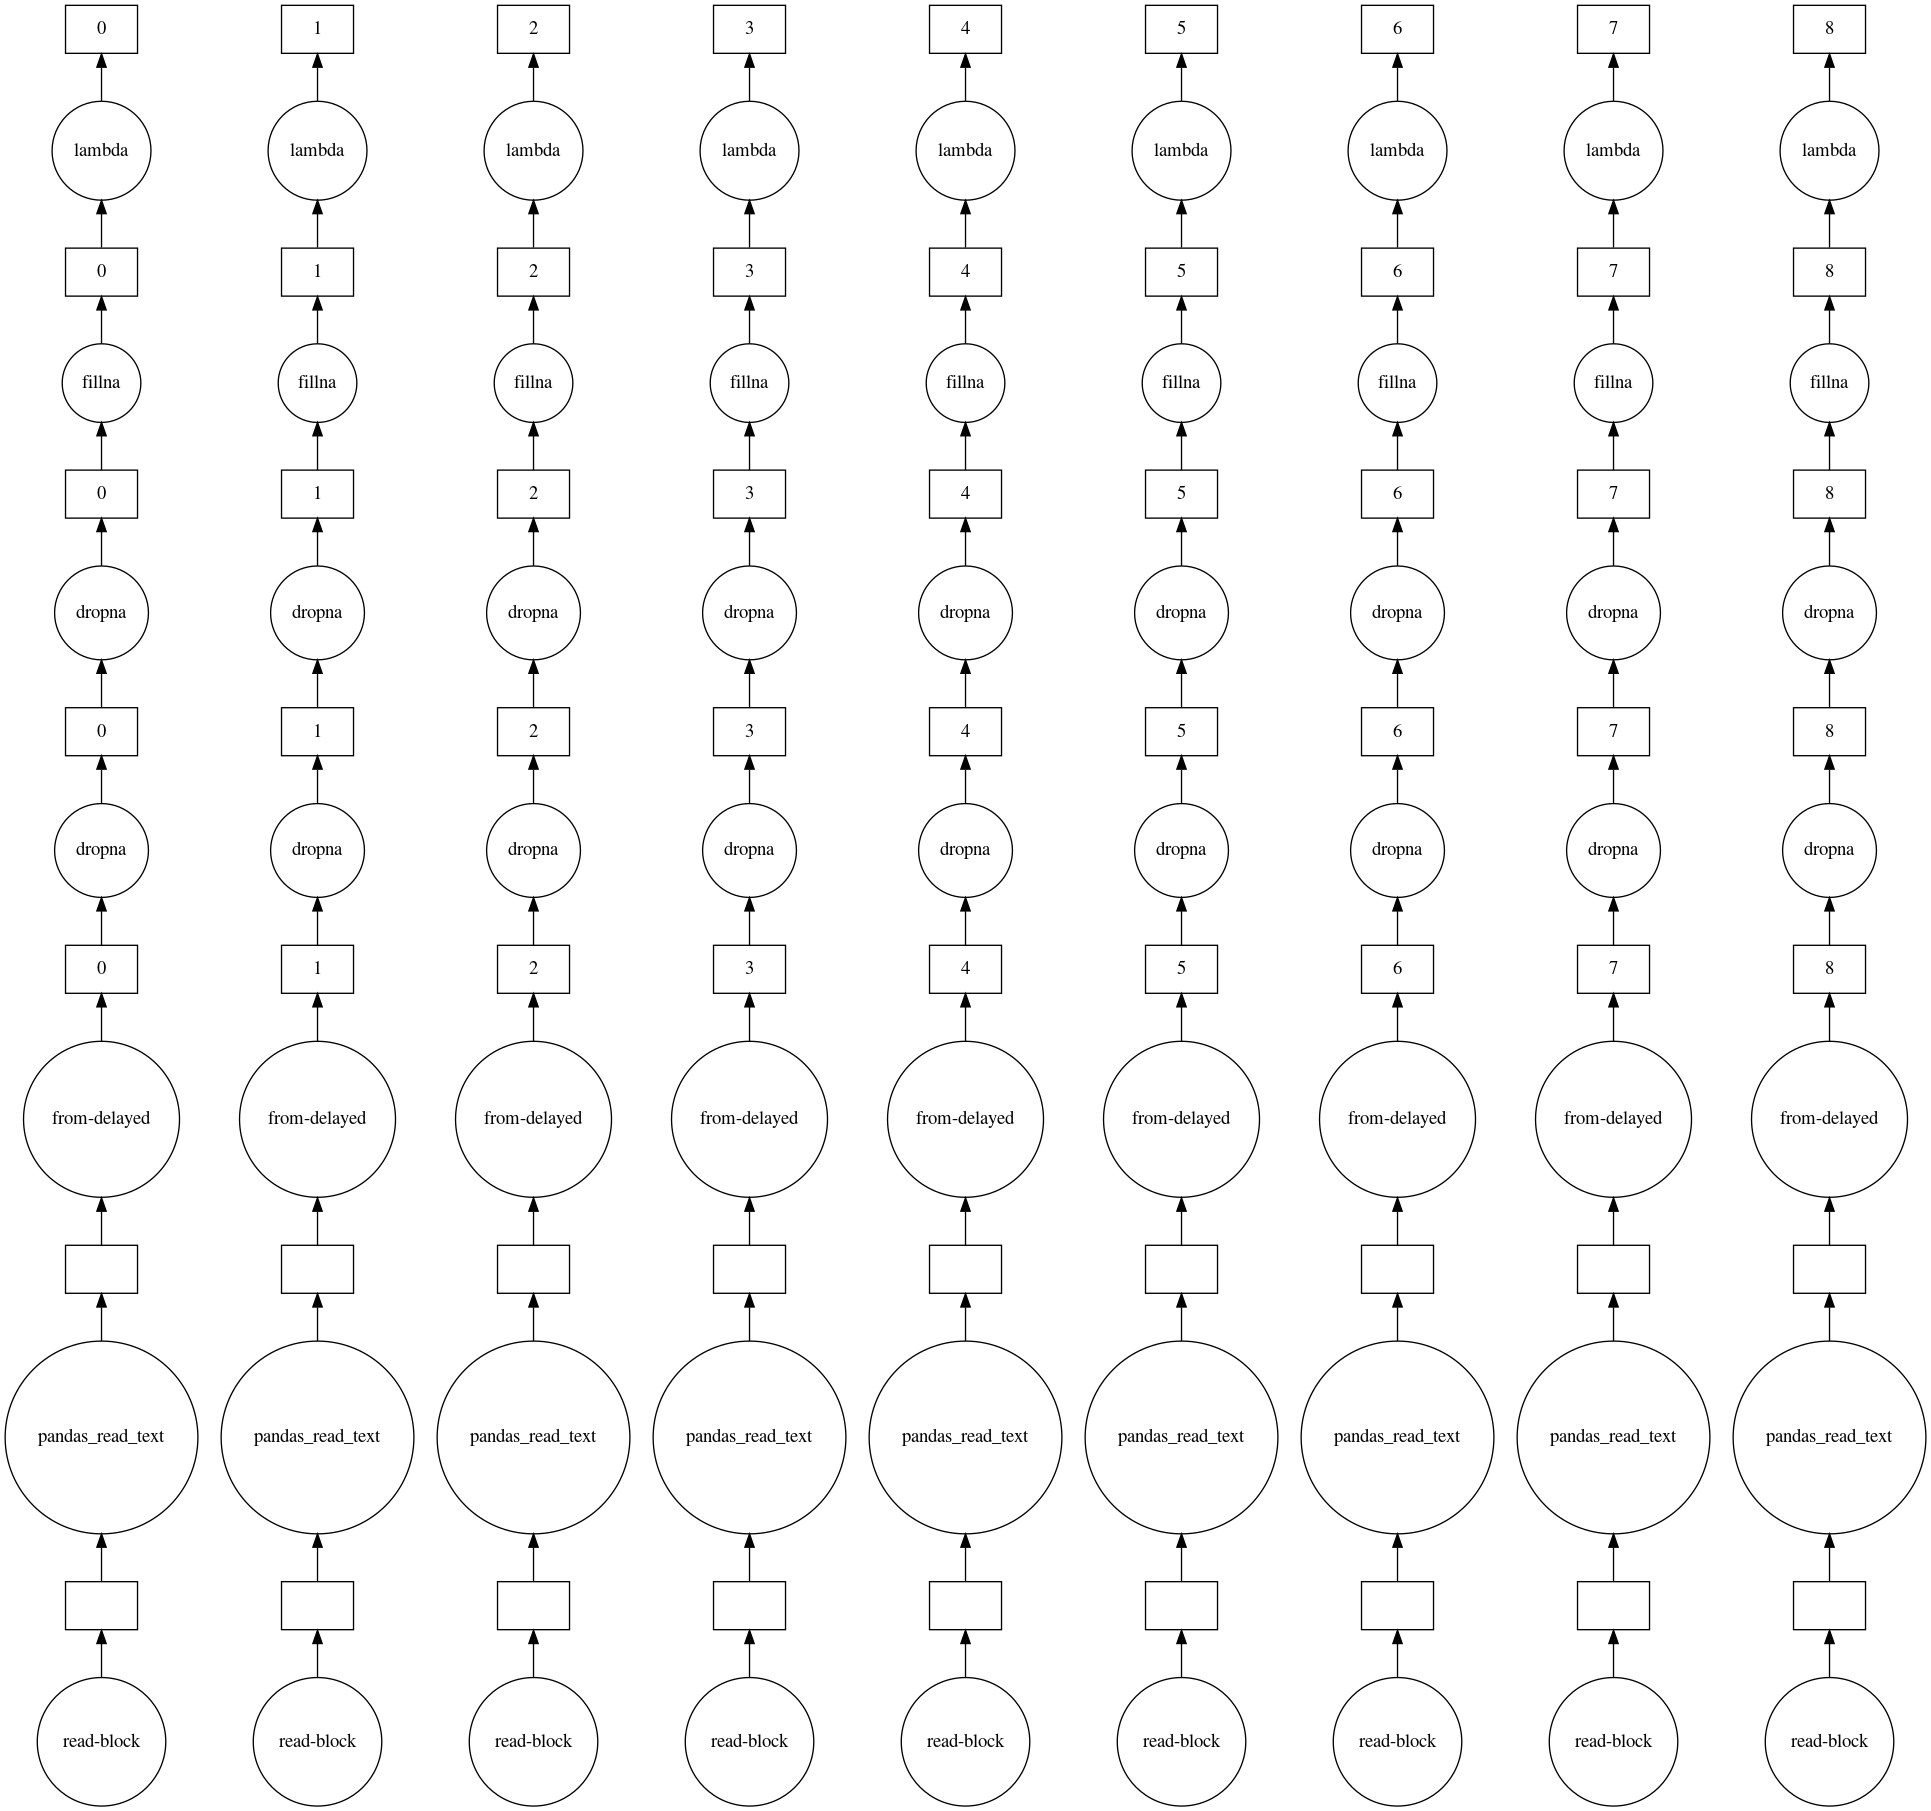

In [22]:
"""metadata_body_col_dd = metadata_dd.map_partitions(
    lambda df: retrieve_paper_body_text_for_series(df.pdf_json_files)
)
metadata_body_col_dd  # Dask.Series
metadata_body_col_dd.visualize()"""

metadata_dd = metadata_dd.map_partitions(
    lambda df: df.assign(body=retrieve_paper_body_text_for_series(df.pdf_json_files))
)
metadata_dd.visualize()

In [23]:
%%time

# metadata_body_col_dd.get_partition(0).memory_usage(deep=True).compute()
print(metadata_dd.npartitions)
metadata_dd.get_partition(0).memory_usage(deep=True).sum().compute()  # 2GB

9
CPU times: user 1.32 s, sys: 227 ms, total: 1.55 s
Wall time: 34.7 s


2019666122

In [24]:
metadata_dd = metadata_dd.repartition(partition_size="100MB")

In [25]:
%%time

import random

"""metadata_body_col_dd = metadata_body_col_dd.repartition(partition_size="100MB")
print(metadata_body_col_dd.npartitions)
print(metadata_body_col_dd.get_partition(0).memory_usage(deep=True).compute())"""

print(metadata_dd.npartitions)
rand_partition_num = random.randint(0, metadata_dd.npartitions)
print(f"{rand_partition_num}: {metadata_dd.get_partition(rand_partition_num).memory_usage(deep=True).sum().compute()}")

69
18: 5019511
CPU times: user 1.35 s, sys: 259 ms, total: 1.61 s
Wall time: 34.8 s


In [ ]:
list(client.scheduler_info()["workers"].values())[1]

In [26]:
%%time

# Runs into MemoryError:
# metadata_body_col_dd.compute(scheduler="processes")

# Write research paper bodies into parquet file
# If compute_kwargs={"scheduler": "processes"} (multiprocessing), workers run out of memory. Why tf does this happen?
dd.to_parquet(
    metadata_dd,
    "research_paper_bodies/", 
    engine="fastparquet",
    compute_kwargs={"scheduler": "synchronous"},  # synchronous ~2m40s
)

CPU times: user 1min 49s, sys: 15.4 s, total: 2min 4s
Wall time: 2min 38s


In [27]:
%%time

"""Generate tfidf embeddings for title and abstract"""
"""
metadata_dd = metadata_dd.map_partitions(
    lambda df: df.assign(
        title_tfidf_embedding=generate_embeddings("tfidf", df.title)
    )
)
metadata_dd = metadata_dd.map_partitions(
    lambda df: df.assign(
        abstract_tfidf_embedding=generate_embedding("tfidf", df.abstract)
    )
)
"""

CPU times: user 36 µs, sys: 5 µs, total: 41 µs
Wall time: 52.5 µs


'\nmetadata_dd = metadata_dd.map_partitions(\n    lambda df: df.assign(\n        title_tfidf_embedding=generate_embeddings("tfidf", df.title)\n    )\n)\nmetadata_dd = metadata_dd.map_partitions(\n    lambda df: df.assign(\n        abstract_tfidf_embedding=generate_embedding("tfidf", df.abstract)\n    )\n)\n'

In [ ]:
%%time

def get_partition_size(dd, n):
    return dd.get_partition(n).memory_usage(deep=True).sum().compute()

def get_df_size(df):
    return df.memory_usage(deep=True).sum()
    
total_mem_usage = get_df_size(metadata_dd).compute()
print(f"Total memory usage of metadata_dd: {total_mem_usage}")
mem_usages_by_partition = metadata_dd.map_partitions(get_df_size).compute()
print(f"Memory usage by partition: {mem_usages_by_partition}")

Below cell will run into OOM error since compute() function loads the result (in this case, the entire df) into memory. <br>
Thus, we have to figure out a way to keep it as a lazily loaded dask.Dataframe even after transformation. <br>

There are two ways of doing this:<br>
1. Write lazy Dask dataframe (delayed object) into several Parquet files (done in parallel by Dask). Then we load these files in serially (making sure each partition < 100 MB) as a dataframe in memory and insert it into Elasticsearch. <br>
2. Simply compute each partition (making sure each partition < 100 MB) and insert it into Elasticsearch. <br>
Let's try the two approaches and see which one's faster. <br>

Confirm memory size of each partition by calling `dd.get_partition(n).compute().memory_usage().sum()`.

In [ ]:
# Note: Don't want to do this, especially since the whole point of Dask is to never load entire dataframes into memory:
# metadata_dd.compute(scheduler="processes")

COVID19_PAPERS_INDEX = "covid19_papers"
DATA_TYPE = "research_paper"
UPLOAD_CHUNK_SIZE = 500

def rec_to_actions(df, index, data_type):
    for record in df.to_dict(orient="records"):
        record_id = record["cord_uid"]
        yield (
            '{ "index" : { "_index" : "%s", "_type" : "%s", "_id": "%s" }}'
            % (index, data_type, record_id)
        )
        yield (json.dumps(record))

def upload_in_memory_papers_to_es_idx(
    papers_df, es_idx, es_hosts, data_type=DATA_TYPE, chunk_size=UPLOAD_CHUNK_SIZE
):
    """
    Uploading Pandas DF to Elasticsearch Index: https://stackoverflow.com/questions/49726229/how-to-export-pandas-data-to-elasticsearch
    """
    # TODO: Catch other exceptions in the future: https://elasticsearch-py.readthedocs.io/en/master/exceptions.html
    try:
        es = Elasticsearch(hosts=es_hosts)
        es.indices.create(index=es_idx, ignore=400)
    except RequestError:
        print(f"Index {es_idx} already exists; continue uploading papers to {es_idx}")

    try:
        idx = 0
        # num_rows = papers_df.shape[0].compute()
        num_rows = chunk_size
        while idx < num_rows:
            if idx + chunk_size < num_rows:
                max_idx = idx + chunk_size
            else:
                max_idx = num_rows

            start = time.time()
            # TODO: Due to partitioning, index of dask.Dataframe are NOT unique! They reset upon a new partition.
            # To fix this:
            # 1. Repartition to 100MB size
            # 2. Modify http_max_content_length in docker-compose.yml file under env
            # 3. Call compute on each partition (.get_partition(n).compute(scheduler="processes"))
            # Won't be parallel anymore (since parallelization is done across partitions), 
            # but at least Dask helps us in dealing with OOM datasets (solves OOM problem but not parallelization)
            # Thus, it could be argued that we don't even need Dask in this case. We could simply read in the
            # pandas df as chunks (instead of partitions) 
            # Modifying elasticsearch.yml configs: 
            # https://discuss.elastic.co/t/elastic-cluster-docker-or-vm-for-production/203567
            # https://stackoverflow.com/questions/44002643/how-to-use-the-official-docker-elasticsearch-container
            # Reminder that we have to go to these lengths b/c Dask indices are dependent on partitions and 
            # doesn't support 
            papers_df_chunk = papers_df.loc[idx:max_idx].compute(scheduler="processes")
            end = time.time()
            print(f"Chunk compute time: {end - start}")
            print(f"Papers chunk memory size: {papers_df_chunk.memory_usage(deep=True).sum()}")
            r = es.bulk(rec_to_actions(papers_df_chunk, es_idx, data_type))
            print(f"Uploaded {papers_df_chunk.shape[0]} papers")
            end_2 = time.time()
            print(f"Chunk upload time: {end_2 - end}")
            idx = max_idx
            print(f"Errors: {r['errors']}")
            
    except TransportError as te:
        transport_error_413_url = "https://github.com/elastic/elasticsearch/issues/2902"
        transport_error_429_urls = [
            "https://stackoverflow.com/questions/61870751/circuit-breaking-exception-parent-data-too-large-data-for-http-request",
            "https://github.com/elastic/elasticsearch/issues/31197",
        ]
        if te.status_code == 413:
            print(
                f"Transport error with status code 413. Chunk size is too large, so try reducing chunk size constant or increase http.max_content_length in the yml file. More info here: {transport_error_413_url}"
            )
        elif te.status_code == 429:
            print(
                f"Transport error with status code 429. Elasticsearch's JVM heap size is too small, so try increasing ES_HEAP_SIZE env var in docker-compose.yml. More info here: {transport_error_429_urls}"
            )
        print(f"Error stacktrace: {te.error, te.info}")
        return

In [28]:
# Note: Don't want to do this, especially since the whole point of Dask is to never load entire dataframes into memory:
# metadata_dd.compute(scheduler="processes")

COVID19_PAPERS_INDEX = "covid19_papers"
DATA_TYPE = "research_paper"
UPLOAD_CHUNK_SIZE = 500

def rec_to_actions(df, index, data_type):
    for record in df.to_dict(orient="records"):
        record_id = record["cord_uid"]
        yield (
            '{ "index" : { "_index" : "%s", "_type" : "%s", "_id": "%s" }}'
            % (index, data_type, record_id)
        )
        yield (json.dumps(record))

def upload_parquet_dir_to_es_idx(
    parquet_dir, es_idx, es_hosts, data_type=DATA_TYPE, chunk_size=UPLOAD_CHUNK_SIZE
):
    """
    Uploading Pandas DF to Elasticsearch Index: https://stackoverflow.com/questions/49726229/how-to-export-pandas-data-to-elasticsearch
    """
    # TODO: Catch other exceptions in the future: https://elasticsearch-py.readthedocs.io/en/master/exceptions.html
    try:
        es = Elasticsearch(hosts=es_hosts)
        es.indices.create(index=es_idx, ignore=400)
    except RequestError:
        print(f"Index {es_idx} already exists; continue uploading papers to {es_idx}")

    try:
        papers_dd = dd.read_parquet(parquet_dir, engine="fastparquet")
        for partition_num in range(papers_dd.npartitions):
            start = time.time()
            papers_dd_partition = papers_dd.get_partition(partition_num)
            papers_df_partition = papers_dd_partition.compute()
            compute_end = time.time()
            print(f"Chunk compute time: {compute_end - start}")
            print(f"Papers chunk memory size: {papers_df_partition.memory_usage(deep=True).sum()}")
            print(f"Number of papers in partition: {papers_df_partition.shape[0]}")
            r = es.bulk(rec_to_actions(papers_df_partition, es_idx, data_type))
            upload_end = time.time()
            print(f"Chunk upload time: {upload_end - compute_end}")
            
    except TransportError as te:
        transport_error_413_url = "https://github.com/elastic/elasticsearch/issues/2902"
        transport_error_429_urls = [
            "https://stackoverflow.com/questions/61870751/circuit-breaking-exception-parent-data-too-large-data-for-http-request",
            "https://github.com/elastic/elasticsearch/issues/31197",
        ]
        if te.status_code == 413:
            print(
                f"Transport error with status code 413. Chunk size is too large, so try reducing chunk size constant or increase http.max_content_length in the yml file. More info here: {transport_error_413_url}"
            )
        elif te.status_code == 429:
            print(
                f"Transport error with status code 429. Elasticsearch's JVM heap size is too small, so try increasing ES_HEAP_SIZE env var in docker-compose.yml. More info here: {transport_error_429_urls}"
            )
        print(f"Error stacktrace: {te.error, te.info}")
        return

In [29]:
%%time

upload_parquet_dir_to_es_idx("research_paper_bodies/*", COVID19_PAPERS_INDEX, ["localhost"])

Chunk compute time: 1.7851262092590332
Papers chunk memory size: 131781511
Number of papers in partition: 2342


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 5.860680818557739
Chunk compute time: 0.6865420341491699
Papers chunk memory size: 145404973
Number of papers in partition: 2343


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 5.90060830116272
Chunk compute time: 0.8845219612121582
Papers chunk memory size: 196862100
Number of papers in partition: 2342


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 8.761472225189209
Chunk compute time: 0.46030306816101074
Papers chunk memory size: 97652762
Number of papers in partition: 2343


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 4.828441143035889
Chunk compute time: 0.6419668197631836
Papers chunk memory size: 147076744
Number of papers in partition: 2342


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 6.588435411453247
Chunk compute time: 0.37312841415405273
Papers chunk memory size: 90715853
Number of papers in partition: 2343


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 3.887591600418091
Chunk compute time: 1.0151867866516113
Papers chunk memory size: 227950272
Number of papers in partition: 2342


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 9.152340173721313
Chunk compute time: 0.8133549690246582
Papers chunk memory size: 183880224
Number of papers in partition: 2343


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 7.932429313659668
Chunk compute time: 0.30170607566833496
Papers chunk memory size: 68766345
Number of papers in partition: 2342


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 3.4530563354492188
Chunk compute time: 0.8193812370300293
Papers chunk memory size: 192881032
Number of papers in partition: 2343


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 8.353768348693848
Chunk compute time: 0.741386890411377
Papers chunk memory size: 163731886
Number of papers in partition: 2342


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 7.531325101852417
Chunk compute time: 0.33135223388671875
Papers chunk memory size: 79035780
Number of papers in partition: 2343


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 3.615985155105591
Chunk compute time: 0.3645451068878174
Papers chunk memory size: 80737391
Number of papers in partition: 2342


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 3.7802610397338867
Chunk compute time: 0.32657504081726074
Papers chunk memory size: 68955911
Number of papers in partition: 2343


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 3.230070114135742
Chunk compute time: 0.25176048278808594
Papers chunk memory size: 58392869
Number of papers in partition: 2342


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 2.8110671043395996
Chunk compute time: 0.252666711807251
Papers chunk memory size: 60337889
Number of papers in partition: 2343


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 3.0220205783843994
Chunk compute time: 0.046926259994506836
Papers chunk memory size: 5090216
Number of papers in partition: 2342


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 0.39020776748657227
Chunk compute time: 0.03749418258666992
Papers chunk memory size: 5170270
Number of papers in partition: 2343


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 0.41483616828918457
Chunk compute time: 0.03772091865539551
Papers chunk memory size: 5019511
Number of papers in partition: 2342


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 0.4062998294830322
Chunk compute time: 0.03815889358520508
Papers chunk memory size: 5178962
Number of papers in partition: 2343


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 0.5409994125366211
Chunk compute time: 0.12241339683532715
Papers chunk memory size: 5043621
Number of papers in partition: 2343


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 0.45317554473876953
Chunk compute time: 0.4881753921508789
Papers chunk memory size: 90615823
Number of papers in partition: 41390


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 7.744546175003052
Chunk compute time: 0.14365792274475098
Papers chunk memory size: 30291174
Number of papers in partition: 13775


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 2.580942153930664
Chunk compute time: 0.5620148181915283
Papers chunk memory size: 117437832
Number of papers in partition: 13775


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 6.478722095489502
Chunk compute time: 0.2731974124908447
Papers chunk memory size: 52677674
Number of papers in partition: 13776


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 3.611220598220825
Chunk compute time: 0.41723084449768066
Papers chunk memory size: 80990799
Number of papers in partition: 18340


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 5.096600532531738
Chunk compute time: 0.3644595146179199
Papers chunk memory size: 78343065
Number of papers in partition: 18340


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 5.174802780151367
Chunk compute time: 0.40221571922302246
Papers chunk memory size: 75949773
Number of papers in partition: 18318


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 5.036653280258179
Chunk compute time: 0.48787760734558105
Papers chunk memory size: 78619678
Number of papers in partition: 18318


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 5.28656530380249
Chunk compute time: 0.0883185863494873
Papers chunk memory size: 16432958
Number of papers in partition: 3738


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 1.116797924041748
Chunk compute time: 0.07760119438171387
Papers chunk memory size: 17274967
Number of papers in partition: 3739


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 1.168879747390747
Chunk compute time: 0.14589357376098633
Papers chunk memory size: 30577077
Number of papers in partition: 3739


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 1.8644037246704102
Chunk compute time: 0.675818681716919
Papers chunk memory size: 130718568
Number of papers in partition: 3738


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 6.547251462936401
Chunk compute time: 0.5861146450042725
Papers chunk memory size: 126281823
Number of papers in partition: 3739


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 6.140889406204224
Chunk compute time: 0.5828578472137451
Papers chunk memory size: 125141792
Number of papers in partition: 3739


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 6.1146533489227295
Chunk compute time: 0.6199309825897217
Papers chunk memory size: 125021329
Number of papers in partition: 3738


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 6.3065526485443115
Chunk compute time: 0.6066558361053467
Papers chunk memory size: 130056253
Number of papers in partition: 3739


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 6.404177665710449
Chunk compute time: 0.5703604221343994
Papers chunk memory size: 124496200
Number of papers in partition: 3739


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 5.9972991943359375
Chunk compute time: 0.5800602436065674
Papers chunk memory size: 127419221
Number of papers in partition: 3739


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 6.350441217422485
Chunk compute time: 0.4477968215942383
Papers chunk memory size: 100636950
Number of papers in partition: 2896


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 4.731717348098755
Chunk compute time: 0.432513952255249
Papers chunk memory size: 99968056
Number of papers in partition: 2897


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 5.16713285446167
Chunk compute time: 0.4294731616973877
Papers chunk memory size: 97950175
Number of papers in partition: 2897


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 4.731663465499878
Chunk compute time: 0.4108126163482666
Papers chunk memory size: 94195280
Number of papers in partition: 2897


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 4.981873989105225
Chunk compute time: 0.4839637279510498
Papers chunk memory size: 105172960
Number of papers in partition: 2897


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 5.400135278701782
Chunk compute time: 0.4290428161621094
Papers chunk memory size: 95519406
Number of papers in partition: 2897


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 4.702991485595703
Chunk compute time: 0.4621288776397705
Papers chunk memory size: 101080546
Number of papers in partition: 2897


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 4.96285605430603
Chunk compute time: 0.45519232749938965
Papers chunk memory size: 102021314
Number of papers in partition: 2897


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 5.384646415710449
Chunk compute time: 0.4536933898925781
Papers chunk memory size: 100375780
Number of papers in partition: 2897


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 5.016437768936157
Chunk compute time: 0.4709758758544922
Papers chunk memory size: 98788701
Number of papers in partition: 2897


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 4.731437921524048
Chunk compute time: 0.43912220001220703
Papers chunk memory size: 102715088
Number of papers in partition: 2897


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 5.019156217575073
Chunk compute time: 0.4007439613342285
Papers chunk memory size: 97789440
Number of papers in partition: 2897


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 4.6330249309539795
Chunk compute time: 0.4627063274383545
Papers chunk memory size: 103029646
Number of papers in partition: 2897


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 5.1256630420684814
Chunk compute time: 0.45447397232055664
Papers chunk memory size: 99603319
Number of papers in partition: 2918


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 4.957114219665527
Chunk compute time: 0.456683874130249
Papers chunk memory size: 99132431
Number of papers in partition: 2918


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 4.954034805297852
Chunk compute time: 0.41417741775512695
Papers chunk memory size: 95488988
Number of papers in partition: 2919


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 4.817539215087891
Chunk compute time: 0.4592299461364746
Papers chunk memory size: 98494591
Number of papers in partition: 2918


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 4.893334865570068
Chunk compute time: 0.4306657314300537
Papers chunk memory size: 98048341
Number of papers in partition: 2918


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 4.998810052871704
Chunk compute time: 0.547621488571167
Papers chunk memory size: 98788361
Number of papers in partition: 2919


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 10.401020765304565
Chunk compute time: 0.4534933567047119
Papers chunk memory size: 98585599
Number of papers in partition: 2918


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 4.763429880142212
Chunk compute time: 0.4680049419403076
Papers chunk memory size: 100689072
Number of papers in partition: 2919


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 4.920915126800537
Chunk compute time: 0.44078683853149414
Papers chunk memory size: 100975060
Number of papers in partition: 2918


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 4.663854598999023
Chunk compute time: 0.4526660442352295
Papers chunk memory size: 99037724
Number of papers in partition: 2918


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 4.919492721557617
Chunk compute time: 0.45700907707214355
Papers chunk memory size: 100117604
Number of papers in partition: 2919


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 4.989971160888672
Chunk compute time: 0.43088531494140625
Papers chunk memory size: 97010672
Number of papers in partition: 2918


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 4.782870054244995
Chunk compute time: 0.4515500068664551
Papers chunk memory size: 98259656
Number of papers in partition: 2919


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 4.784783840179443
Chunk compute time: 0.37438082695007324
Papers chunk memory size: 83792505
Number of papers in partition: 2494


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 4.254506587982178
Chunk compute time: 0.3855404853820801
Papers chunk memory size: 85723363
Number of papers in partition: 2495


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 4.223361253738403
Chunk compute time: 0.374570369720459
Papers chunk memory size: 82905575
Number of papers in partition: 2495


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Chunk upload time: 3.975001811981201
Chunk compute time: 0.356107234954834
Papers chunk memory size: 83798591
Number of papers in partition: 2495
Chunk upload time: 4.280253648757935
CPU times: user 41 s, sys: 11.1 s, total: 52.1 s
Wall time: 6min 1s


/home/nrs/.local/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


**Chunk size: 100** <br>
Chunk compute time: 53.44560766220093 <br>
Papers chunk memory size: 63760 <br>
Uploaded 797 papers <br>
Chunk upload time: 1.0919387340545654 <br>
Errors: False <br>
CPU times: user 2.52 s, sys: 456 ms, total: 2.97 s<br>
Wall time: 54.6 s <br>

**Chunk size: 1000** <br>
Chunk compute time: 50.61113500595093 <br>
Papers chunk memory size: 170575504 <br>
This is when it hits the 413 TransportError b/c in the elasticsearch.yml file of the container, the config var `http.max_content_length = 100MB`, and the papers df chunk memory size = 170.58MB. 

In [ ]:
%%time

# 6.5GB total - 46.5 s
metadata_dd.memory_usage(deep=True).sum().compute(scheduler="processes")

In [ ]:
metadata_dd.partitions

In [ ]:
%%time

metadata_chunk = metadata_dd.loc[0].compute()
metadata_chunk_2 = metadata_dd.loc[0:1000].compute()

In [ ]:
metadata_chunk_2.shape

In [ ]:
metadata_df[metadata_df["cord_uid"] == "soksrmkx"]
metadata_dd.index.value_counts().compute()